# Distance Analysis Script
### Code for overall distance violin plots & closest neighbours sankey diagram
This Jupyter Notebook contains code for the distance analysis steps in the overall image analysis pipeline.

Usage: Please run this Notebook cell-by-cell. If a cell begins with "### USER-INPUT ###", the user can change variables to change the scope or some aspects of the analysis. However, the cell can still be run as-is with the default parameters already selected.
If this indicator is not present in a cell, please run it as-is.

If this script is used together with the example data from the GitHub repository, please make sure the folder structure is the same as the one in the GitHub repository as this is important for loading in data.


#### Import necessary packages

In [1]:
import os
import numpy as np # v. 1.26.4
import matplotlib.pyplot as plt # v. 3.8.2
from skimage import io # v. 0.22.0
from skimage.io import imread, imshow # v. 0.22.0
import pandas as pd # v. 2.2.0
from statistics import mean
from scipy.spatial.distance import cdist # v. 1.12.0
from scipy.spatial import distance_matrix # v. 1.12.0
import plotly.graph_objects as go # v. 5.19.0
# python v. 3.10.12

#### Load in data and create data frames

In [58]:
### USER-INPUT ###
"""
Write the sample image you would like to use. 
Make sure the ones you pick are available in the necessary folder as intensity data frames.
On the GitHub repository for this project, only R1B1ROI1 is available as example input, so if you only have 
access to the GitHub, please only use that here.
"""
#img_names = ['R1B1ROI1', 'R1B1ROI2', 'R1C1ROI1', 'R1C1ROI2', 'R1D1ROI1', 'R1D1ROI2']
img_names = ['R1B1ROI1']

In [59]:
# Load in intensity data frames, save dfs, centroids, cell types
# Make sure the folder structure is the same as here
intensitydir = "../00_Data/IntensitiesCelltypes/"

# Initialise data frames
intensitydfs = {}
centroids = {}
celltypes = {}
areas = {}

# Loop through image names, create data frames, 
for i in img_names:
    filename = i + "_intensitiesdf.csv"
    filepath = os.path.join(intensitydir, filename)
    df = pd.read_csv(filepath)
    
    X_coords = df["X_coord"]
    Y_coords = df["Y_coord"]
    centroidsdf = df[["X_coord", "Y_coord"]]
    centroids[i] = centroidsdf

    celltype = df["InferredCellType"]
    celltypes[i] = celltype
    
    area = df["area"]
    areas[i] = area
    
    intensitydfs[i] = df.iloc[:, 1:-4] # drop first column, is just the cell index, and area, inf.c.t. and centroids
    

In [60]:
# Reminder of markers that were used:
markers = list(intensitydfs["R1B1ROI1"].columns)
print("All biomarkers:", markers)
print()

# Reminder of all possible cell types:
print("All cell types:", np.unique(celltypes["R1B1ROI1"]))

All biomarkers: ['actin', 'cd3', 'cd4', 'cd45', 'cd45ro', 'collageni', 'cytokeratin', 'fibulin2', 'lyve1', 'podoplanin', 'cd38', 'cd138']

All cell types: ['B-cells Plasma' 'Epithelial cells' 'Extracellular matrix'
 'Lymphatic vessel' 'Mixed' 'Myocytes' 'Other' 'T-cells CD4+ (helper)'
 'T-cells Memory' 'T-cells Mixed' 'T-cells Naive']


In [61]:
# Showing example of data frame
df.iloc[:, 1:]

,actin,cd3,cd4,cd45,cd45ro,collageni,cytokeratin,fibulin2,lyve1,podoplanin,cd38,cd138,area,X_coord,Y_coord,InferredCellType
0,2267,7279,680,651,4858,1265,5457,6178,1917,3903,618,9684,854,23.176815,9.217799,Other
1,2550,7433,3287,517,15970,2415,5312,6493,1920,538,816,9158,2829,194.078119,21.315659,Mixed
2,1913,8277,5341,1362,9727,1145,6841,4474,2163,5597,1953,9848,3012,305.499668,19.198207,Other
3,2525,7557,1108,298,5619,1564,7415,6858,2010,15072,717,10962,1819,668.349643,17.492029,Mixed
4,4271,7910,915,338,4610,33,7120,3326,1993,3715,548,11231,2130,2061.602817,15.444131,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11729,2365,6330,1051,346,4296,97,4328,1991,1754,2264,629,10322,1533,8530.621005,10324.647750,Other
11730,2159,5598,757,261,7918,290,5407,3446,1401,1199,532,9288,1561,8993.210122,10326.335682,Other
11731,1619,5582,673,552,9131,564,6197,1459,1414,2871,595,9174,1099,5658.414923,10328.585987,Other
11732,2022,6136,838,3116,3484,594,5803,1454,1720,7635,619,9046,2717,5723.713287,10319.609128,Other


## Distance violin plots
#### Description
The code below creates violin plots for the distances between selected cell types for all images that were loaded in.
First, a distance matrix is computed, containing the pairwise distances between every cell in a user-defined selection of cell types.
Then, violin plots are created, showing distance distributions for all selected cell type pairs.

#### Functions
- celltypes_distance_matrix_func() -> computes pairwise distances between cell types. | 
    The user selects one cell type as the chosen group of interest (ct1), and a list of cell types (ct2) for ct1 to be compared to and for which pairwise distances are calculated. The input cell type ct1 can also be all T-cell subtypes pooled if the option pool_tcells is set to True.
- plot_violin() -> plots a violin plot for the distance matrix computed in celltypes_distances_matrix_func()

In [62]:
# Distance Matrix function

# Function for computing distances between two cell types WITH CENTROIDS
def celltypes_distance_matrix_func(ct1, ct2, celltypes_array, centroids_array, pool_tcells=False):

    cellt = celltypes_array
    centr = centroids_array
        
    if pool_tcells == True: # Make all T-cell subtypes into the same called "T-cells"
        cellt = np.where(cellt == "T-cells Mixed", "T-cells", cellt)
        cellt = np.where(cellt == "T-cells Naive", "T-cells", cellt)
        cellt = np.where(cellt == "T-cells CD4+ (helper)", "T-cells", cellt)
        cellt = np.where(cellt == "T-cells Memory", "T-cells", cellt)
        #print(cellt[:10])
        
        
    # If ct2 is just one singular cell type
    if len(ct2) == 1:
        # Getting cell indexes from cell types from celltypes_array
        ct1cells = np.where(cellt == ct1)[0]
        ct2cells = np.where(cellt == ct2[0])[0]

        # Making centroids arrays for the selected cells
        ct1coords = centr[ct1cells]
        ct2coords = centr[ct2cells]

        # Calculate distance matrix
        dist_mat = distance_matrix(ct1coords, ct2coords, p=2)
        print("In the distance matrix for the cell types {} and {}, there are {} rows and {} columns.".format(ct1, ct2[0], dist_mat.shape[0], dist_mat.shape[1]))
    
        return(dist_mat)

    
    # If ct2 is a list of multiple cell types
    else:
        multiple_dist_mat = {}
        
        for ct in ct2:
            # Getting cell indexes from cell types from celltypes_array
            ct1cells = np.where(cellt == ct1)[0]
            ct2cells = np.where(cellt == ct)[0]

            # Making centroids arrays for the selected cells
            ct1coords = centr[ct1cells]
            ct2coords = centr[ct2cells]

            # Calculate distance matrix
            dist_mat = distance_matrix(ct1coords, ct2coords, p=2)
            print("In the distance matrix for the cell types {} and {}, there are {} rows and {} columns.".format(ct1, ct, dist_mat.shape[0], dist_mat.shape[1]))
            #multiple_dist_mat[ct] = dist_mat.flatten()
            multiple_dist_mat[ct] = dist_mat
        
        return(multiple_dist_mat)





#### Run celltypes_distance_matrix_func() on input data
Save results to dictionary for easy acces. 
This is mainly done in case there are multiple input data frames.

In [63]:
#### USER-INPUT ####
"""
Can change ct1 and ct2 if desired.
If ct1 == "T-cells", pool_tcells must be set to True.
Otherwise, ct1 can be any singular other cell type. Check above for the available cell types to choose from.
Ct2 can also be just one cell type, but it must be saved in a list, e.g. ct2 = ["Myocytes"].
"""

# Make distance matrices for pooled t cells
# Initialise dictionary for saving matrices
dist_mat_pooled_t = {}
ct1 = "T-cells"
ct2 = ["Epithelial cells", "Extracellular matrix", "Lymphatic vessel", "Myocytes", "Mixed"]
pool_tcells = True


# Loop through images, create data frames by running function, save to dict
for i in img_names:
    celltypes_array = celltypes[i].to_numpy()
    centroids_array = centroids[i].to_numpy()
    dist_mat = celltypes_distance_matrix_func(ct1, 
                                              ct2, 
                                              celltypes_array, 
                                              centroids_array, 
                                              pool_tcells=pool_tcells)
    dist_mat_pooled_t[i] = dist_mat
    print()



In the distance matrix for the cell types T-cells and Epithelial cells, there are 842 rows and 1974 columns.
In the distance matrix for the cell types T-cells and Extracellular matrix, there are 842 rows and 1319 columns.
In the distance matrix for the cell types T-cells and Lymphatic vessel, there are 842 rows and 209 columns.
In the distance matrix for the cell types T-cells and Myocytes, there are 842 rows and 467 columns.
In the distance matrix for the cell types T-cells and Mixed, there are 842 rows and 4513 columns.



#### Create function for making violin plots
This function uses the above defined ct1 and ct2 as inputs. 

The plots are returned. You can either show the plots by running the function (show=True) or not (show=False), just saving them to the output through the return statement.

The input data_dict is a distance matrix such as created above.

The "name" variable is a string that should be the name of the image you are showing. It will be used in the plot title.

In [64]:
def plot_violin(data_dict, name, ct1, ct2, show=False):
    
    if len(ct2) == 1:
        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(10, 6))

        # Create the violin plot
        parts = ax.violinplot(data_dict.flatten(), showmeans=True, showmedians=False)

        # Customize the plot (optional)
        ax.set_title("Violin plot of {} distances to {} for {}".format(ct1, ct2[0], name))
        ax.set_xlabel(ct2[0])
        ax.set_ylabel("Distances")

        if show:
            # Show the plot
            plt.tight_layout()
            plt.show()
        else:
            plt.close(fig)
        
    else:
        keys = list(data_dict.keys())
        data = [data_dict[key].flatten() for key in keys]

        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(10, 6))

        # Create the violin plot
        parts = ax.violinplot(data, showmeans=True, showmedians=False)

        # Set the x-ticks and x-tick labels
        ax.set_xticks(np.arange(1, len(keys) + 1))
        ax.set_xticklabels(keys)

        # Compute and plot the means manually (optional customization)
        means = [np.mean(d) for d in data]
        ax.scatter(np.arange(1, len(keys) + 1), means, color='red', marker='o', s=50, zorder=3, label='Mean')

        # Annotate the means with their values
        for j, mean in enumerate(means):
            ax.text(j + 1, mean, f'{mean:.2f}', ha='center', va='bottom', fontsize=10, color='red')


        # Customize the plot (optional)
        title = "Violin plot of {} distances to other cell types for {}".format(ct1, name)
        ax.set_title(title)
        ax.set_xlabel('Inferred Cell Types')
        ax.set_ylabel('Distances')

        if show:
            # Show the plot
            plt.tight_layout()
            plt.show()
        else:
            plt.close(fig)
    
    return fig
    
# Usage: fig = plot_violin(dist_mat_pooled_t["R1B1ROI1"], "R1B1ROI1", ct1, ct2, show=True)

#### Create violin plots for all images in distance matrix dictionary
You can also run this if the distance matrix dictionary only has one image.

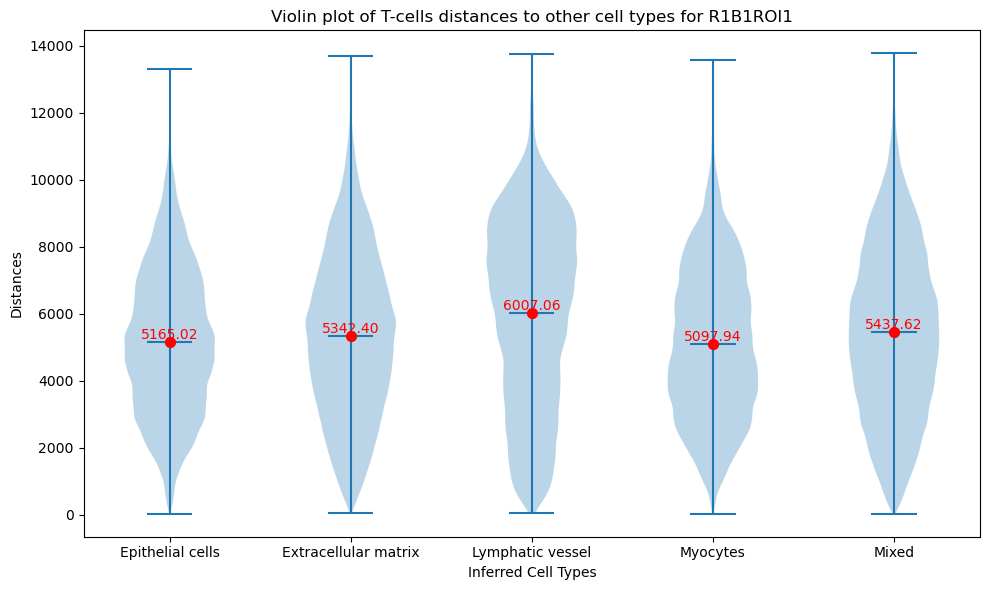

In [65]:
# Create separate violin plots for all images
# Initialise dictionary
figures_pooled_t = {}

# Loop through images and create plots
for i in img_names:
    fig = plot_violin(dist_mat_pooled_t[i], i, ct1, ct2, show=True)
    figures_pooled_t[i] = fig
    # Plots will be saved in figures_pooled_t[i]


#### Pool all images
Make a combined data frame for all images to see the overall distances

In [56]:
if len(dist_mat_pooled_t) > 1:
    # Make pooled dist mat for all images
    dist_mat_pooled_t_ALLIMG = {}

    for ct in ct2: # Loop through cell types
        for i in dist_mat_pooled_t: # Loop through images
            img = dist_mat_pooled_t[i]
            flat_array = img[ct].flatten()
            if ct in dist_mat_pooled_t_ALLIMG:
                dist_mat_pooled_t_ALLIMG[ct] = np.concatenate((dist_mat_pooled_t_ALLIMG[ct], flat_array))
            else:
                dist_mat_pooled_t_ALLIMG[ct] = flat_array
else:
    print("You only have one image, so there is no need to pool images. The result would be the same.")



#### Show violin plot for all pooled images
This plot will be the same as the previous plot IF there is only one image in the dictionary.

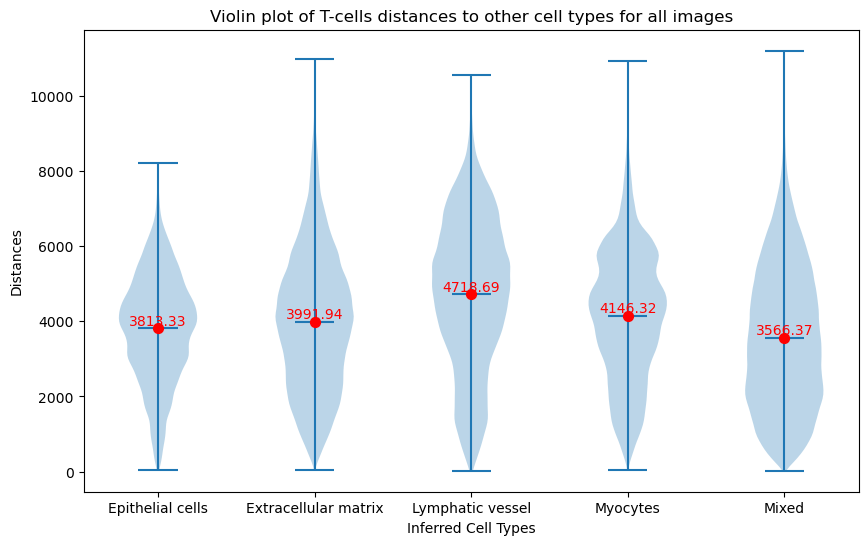

In [57]:
try:
    all_img_fig = plot_violin(dist_mat_pooled_t[i], "all images", ct1, ct2, show=False)
    plt.figure(all_img_fig)
    plt.show()
except:
    print("You only have one image, so there is no need to pool images. The result would be the same.")
    

#### How to save the figures and just plot one figure in the dictionary

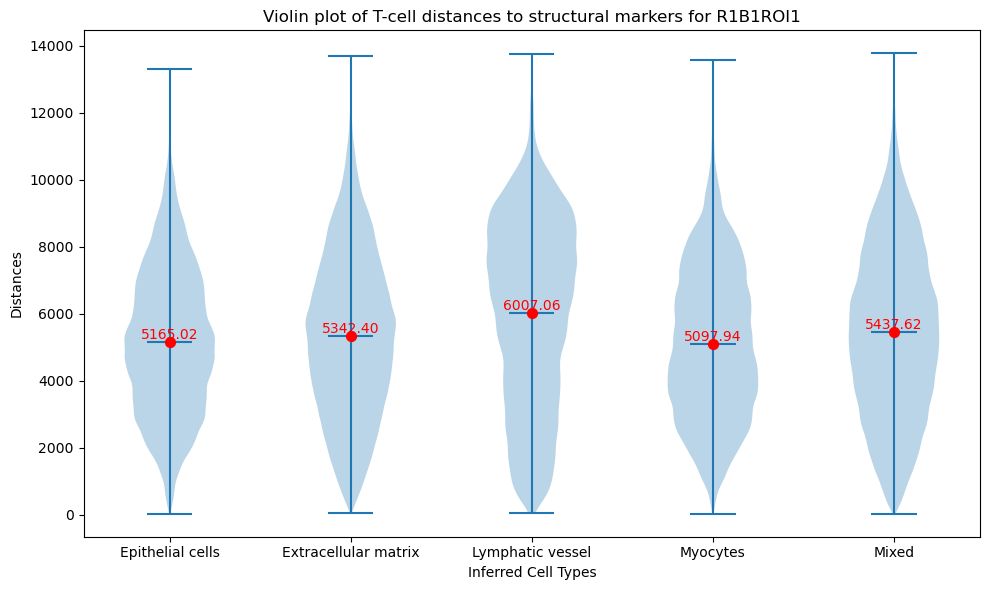

In [64]:
# Save figures to folder - uncomment to run
#for key, fig in figures_pooled_t.items():
    #fig.savefig(f'violin_plot_{key}.png')
    
# Plot just one:
plt.figure(figures_pooled_t["R1B1ROI1"])
plt.show()

## Sankey diagram
#### Description
In the code below, we are creating a sankey diagram. This diagram shows the closest neighbours to every cell in the "source" category.
A radius is specified by the user which determines the number of closest neighbours that should be identified for every "source" cell.

So for every cell, the r closest cells are computed and their cell types are identified. Then, for the r neighbouring cell types, the average distances are computed. The cell type that is on average closest to the source cell is chosen as the closest cell type and will later be the one identified in the sankey diagram.

#### Functions
- create_fromtotable -> creates a table with the source (from) cell types, the target (to) cell types, and the amount of cases in which the closest cell type to the source cell type was the target.
- create_sankey -> creates sankey plots

In [98]:
# Function for creating table with sources (from) and targets (to) of sankey diagram
def create_fromtotable(celltypes_array, centroids_array, from_cts, to_cts, radius, cellTypes):
    
    cellTypes = np.unique(celltypes_array).tolist()
    
    ### Filtering
    
    # Create from and to dfs
    # "FROM" = on the left side of sankey diagram e.g. all T-cells
    # "TO" = on the right side of sankey diagram, e.g. all structural cell types
    TO_indices_to_keep = np.isin(celltypes_array, to_cts)
    FROM_indices_to_keep = np.isin(celltypes_array, from_cts)

    from_centroids = centroids_array[FROM_indices_to_keep]
    from_celltypes = celltypes_array[FROM_indices_to_keep]

    # Create all other cell types dfs
    to_centroids = centroids_array[TO_indices_to_keep]
    to_celltypes = celltypes_array[TO_indices_to_keep]
   

    ### Conversion (for easier computation)
    
    # Convert structured pandas df to numpy arrays of tuples
    from_centroids = from_centroids.to_records(index=False)  # BY actual index
    from_centroids = np.array([tuple(row) for row in from_centroids])
    to_centroids = to_centroids.to_records(index=False)  # BY actual index
    to_centroids = np.array([tuple(row) for row in to_centroids])
    
    # Convert pandas series to numpy arrays
    from_celltypes = from_celltypes.to_numpy()
    to_celltypes = to_celltypes.to_numpy()
    

    
    ### Initialising data frame
    
    # Initialise data frame with combinations of cell types as columns
    combi = []
    for i in from_cts:
        for j in to_cts:
            if i != j: # Only want to include T-cells in "From"
                combi.append([i, j, 0])
    fromto_df = pd.DataFrame(combi, columns=["From", "To", "Amount"])
    

    
    ### Distances computation

    # Loop through each cell one by one and calculate distances
    for idx in range(len(from_centroids)):
        
        # Calculate distance matrix from this cell idx to all other cells
        cell = from_centroids[idx] # Cell coordinates of current cell
        distances = np.linalg.norm(to_centroids - cell, axis=1) # Np array with all distances for "cell" to all "to" celltypes
        
        # Find cells closest, amount of closest cells specified by radius
        if radius != None:
            distance_idxs = distances.argsort()[:radius] # indexes of closest ones within radius
            distances = distances[distance_idxs] # centroids of closest ones within radius
            selection_celltypes = to_celltypes[distance_idxs] # the cell types of the cells that were closest    
       
        # Find lowest average distance celltype for this specific cell
        averages_distances = [] # Initialise empty dict for averages
        for ct in cellTypes:
            ctdistances = distances[(selection_celltypes == ct)] # Will be empty for all cell types that were not within radius
            
            # Append distance value (or -1 if no cell of this ct near) to averages_distances at the index of ct
            if len(ctdistances) != 0:
                averages_distances.append(np.mean(ctdistances)) 
            else:
                averages_distances.append(-1)

        
        # Add indication about nearest (lowest dist) celltype for this cell to fromto_df
        # Identify the one closest cell type (lowest average distance)
        closest = averages_distances.index(min([i for i in averages_distances if i >= 0])) 
        fromtype = from_celltypes[idx]
        totype = cellTypes[closest]
        # Write to data frame
        fromto_df.loc[(fromto_df["From"] == fromtype) & (fromto_df["To"] == totype), "Amount"] += 1

    return(fromto_df)


# Usage: fromto_df = create_fromtotable(celltypes_array, centroids_array, from_cts, to_cts, radius, cellTypes)


#### Create from-to-tables for every image

In [108]:
### USER-INPUT ###
"""
You can change the radius to check a different number of closest neighbours.
You can also change the source cell types (from_cts) and the target cell types (to_cts).
You can't have the same cell type on both sides.
"""

# Initisalise dictionary
from_to_df_dict = {}

# Define radius
# How big should the radius of cells be? If all cells, put None
radius = 1

# Define which cell types you want on the left (from) and on the right (to) of the sankey diagram
from_cts = ["T-cells Memory", "T-cells Mixed", "T-cells Naive",  "T-cells CD4+ (helper)"]
to_cts = ["Extracellular matrix", "Lymphatic vessel", "Epithelial cells", "Myocytes"]
   
# loop through image names and create tables
for i in img_names:
    cellTypes = np.unique(celltypes[i])
    celltypes_array = celltypes[i]
    centroids_array = centroids[i]
    
    fromto_df = create_fromtotable(celltypes_array, centroids_array, from_cts, to_cts, radius, cellTypes)
    from_to_df_dict[i] = fromto_df
    print("From-To-DF for the image {} created and saved to dict.".format(i))




From-To-DF for the image R1B1ROI1 created and saved to dict.
From-To-DF for the image R1B1ROI2 created and saved to dict.
From-To-DF for the image R1C1ROI1 created and saved to dict.
From-To-DF for the image R1C1ROI2 created and saved to dict.
From-To-DF for the image R1D1ROI1 created and saved to dict.
From-To-DF for the image R1D1ROI2 created and saved to dict.


#### Creating function for making sankey plots

In [109]:
# Function for creating sankey plots
def create_sankey(fromto_df, from_cts, to_cts, name, radius):
    df = fromto_df.copy() # We don't want to change our original data frames
    
    # For the sankey plot, we need indices representing cell types rather than strings
    # Create a list of unique nodes (= all cell types we have in our selection)
    nodes = from_cts + to_cts
    # Create indices for them in a dictionary
    node_indices = {node: i for i, node in enumerate(nodes)}

    # Map 'From' and 'To' to their node indices and temporarily add to df
    df['Source'] = df['From'].map(node_indices)
    df['Target'] = df['To'].map(node_indices)

    # Define the Sankey diagram
    sankey_fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=[node for node in nodes]
        ),
        link=dict(
            source=df['Source'],
            target=df['Target'],
            value=df['Amount']
        )
    ))


    # Update layout and plot the figure
    sankey_fig.update_layout(title_text="Sankey Diagram of {} closest neighbouring cells for {}".format(radius, name), 
                             font_size=10)
    sankey_fig.show()
    
    return(sankey_fig)
    
    
# Usage: sankey_fig = create_sankey(fromto_df, from_cts, to_cts, "R1B1ROI1", radius)

#### Create Sankey Plots
Create sankey plots for all images separately and save them to a dictionary for easy acces.

In [110]:
sankey_plots = {}
for i in img_names:
    create_sankey(from_to_df_dict[i], from_cts, to_cts, i, radius)
    
    
    

#### Pool all images
Make a combined data frame for all images to see the overall distributions of T-cell closest neighbours

In [111]:
if len(from_to_df_dict) > 1:
    # Initialise combined data frame
    combined_from_to_df = None

    # Loop through dfs to add "amount" values together
    for df in from_to_df_dict.values():
        if combined_from_to_df is None:
            combined_from_to_df = df.copy()
        else:
            combined_from_to_df["Amount"] += df["Amount"]

    # Show data frame
    combined_from_to_df
    
else:
    print("You only have one image, so there is no need to pool images. The result would be the same.")
    

#### Create Sankey plot for combined df

In [112]:
try:
    combined_sankey_fig = create_sankey(combined_from_to_df, from_cts, to_cts, "all images", radius)
except:
    print("You only have one image, so there is no need to pool images. The result would be the same.")
    